1. Implement L1 norm regularization as a custom loss function
2. Implement early stopping in the $E_{\text{opt}}$ specification
3. Implement early stopping in one of the additional specifications as of [4](https://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf) 

In [1]:
%reset -f

In [2]:
import torch
import os
import sys
from torch import nn
from matplotlib import pyplot as plt

from scripts import mnist
from scripts.train_utils import accuracy, AverageMeter

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.h1 = nn.Linear(28*28, 16)
        self.h2 = nn.Linear(16, 32)
        self.h3 = nn.Linear(32, 24)
        self.out = nn.Linear(24, 10)
    
    def forward(self, X, activ_hidden=nn.functional.relu):
        out = self.flat(X)
        out = activ_hidden(self.h1(out))
        out = activ_hidden(self.h2(out))
        out = activ_hidden(self.h3(out))
        out = self.out(out)
        return out

In [4]:
def get_params_and_gradients_norm(named_parameters):
    square_norms_params = []
    square_norms_grads = []

    for _, param in named_parameters:

        if param.requires_grad:
            square_norms_params.append((param ** 2).sum())
            square_norms_grads.append((param.grad ** 2).sum())
    
    norm_params = sum(square_norms_params).sqrt().item()
    norm_grads = sum(square_norms_grads).sqrt().item()

    return norm_params, norm_grads

In [5]:
minibatch_size_train = 256
minibatch_size_test = 512

trainloader, testloader, trainset, testset = mnist.get_data(batch_size_train=minibatch_size_test, batch_size_test=minibatch_size_test)

In [6]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory, device): # note: I've added a generic performance to replace accuracy and the device
    for X, y in dataloader:
        # TRANSFER X AND y TO GPU IF SPECIFIED
        X = X.to(device)
        y = y.to(device)
        # ... like last time
        optimizer.zero_grad() 
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        acc = performance(y_hat, y)
        loss_meter.update(val=loss.item(), n=X.shape[0])
        performance_meter.update(val=acc, n=X.shape[0])

        if trajectory is not None:

            params_norm, gradients_norm = get_params_and_gradients_norm(model.named_parameters())
            trajectory["parameters"].append(params_norm)
            trajectory["gradients"].append(gradients_norm)

def train_model(model, dataloader, loss_fn, optimizer, num_epochs, validate_model=False, checkpoint_loc=None, checkpoint_name="checkpoint.pt", performance=accuracy, trajectory=None, device=None, early_stop=False): # note: I've added a generic performance to replace accuracy and an object where to store the trajectory and the device on which to run our training

    # establish device
    if device is None:
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
    print(f"Training on {device}")

    # create the folder for the checkpoints (if it's not None)
    if checkpoint_loc is not None:
        os.makedirs(checkpoint_loc, exist_ok=True)
    
    model.to(device)
    model.train()

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []    
    E_opt = 9999999999 # set it to big value
    # epoch loop
    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        performance_meter = AverageMeter()

        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory, device)

        print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}; Performance: {performance_meter.avg}")
    
        train_loss_list.append(loss_meter.sum)
        train_acc_list.append(performance_meter.avg)
    # add also test_model step for each epoch to validate the model
        if validate_model == True:
            val_loss, val_perf = test_model(model, testloader, performance=accuracy, loss_fn = loss_fn, device = "cuda:0")
            val_loss_list.append(val_loss)
            val_acc_list.append(val_perf)
            
        if early_stop == True:
            
            if val_loss >= E_opt:
                break 
            else:
                E_opt = val_loss
                # produce checkpoint dictionary -- but only if the name and folder of the checkpoint are not None
                if checkpoint_name is not None and checkpoint_loc is not None:
                    # so we can have the latest model
                    checkpoint_dict = {
                        "parameters": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "epoch": epoch
                    }
                    torch.save(checkpoint_dict, os.path.join(checkpoint_loc, checkpoint_name))
        
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list, trajectory

def test_model(model, dataloader, performance=accuracy, loss_fn=None, device=None):
    # establish device
    if device is None:
        device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # create an AverageMeter for the loss if passed
    if loss_fn is not None:
        loss_meter = AverageMeter()
    
    performance_meter = AverageMeter()

    model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            y_hat = model(X)
            loss = loss_fn(y_hat, y) if loss_fn is not None else None
            acc = performance(y_hat, y)
            if loss_fn is not None:
                loss_meter.update(loss.item(), X.shape[0])
            performance_meter.update(acc, X.shape[0])
    # get final performances
    fin_loss = loss_meter.sum if loss_fn is not None else None
    fin_perf = performance_meter.avg
    print(f"TESTING - loss {fin_loss if fin_loss is not None else '--'} - performance {fin_perf}")
    return fin_loss, fin_perf

In [7]:
def plot_trajectory(trajectory, ylim=(0,15)):
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    ax1.set_ylim(*ylim)
    ax1.plot(trajectory["parameters"])
    ax1.set_title("Norm of parameters")
    ax2.plot(trajectory["gradients"])
    ax2.set_title("Norm of gradients")
    plt.show()

In [8]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, num_epochs):
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(9,9))
    ax1.plot(list(range(1,num_epochs+1)),train_loss,label="Train Loss")
    ax1.plot(list(range(1,num_epochs+1)),val_loss, label="Validation Loss")
    ax1.legend()

    ax2.plot(list(range(1,num_epochs+1)),train_acc,label="Train Accuracy")
    ax2.plot(list(range(1,num_epochs+1)),val_acc, label="Validation Accuracy")
    ax2.legend();

Observing the effect of L2 regularisation (taken from lab)

In [9]:
learn_rate = 0.1
num_epochs = 5

model = MLP()
loss_fn = nn.CrossEntropyLoss()
weight_decay = 4e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, weight_decay=weight_decay)

trajectory = {"parameters": [], "gradients": []}

train_loss_list, train_acc_list, val_loss_list, val_acc_list, trajectory = train_model(model, trainloader, loss_fn, optimizer, num_epochs, validate_model = True, trajectory=trajectory, device="cuda:0")

Training on cuda:0
Epoch 1 completed. Loss - total: 86955.94254493713 - average: 1.4492657090822856; Performance: 0.5512
TESTING - loss 50043.91261291504 - performance 0.7181333333333333
Epoch 2 completed. Loss - total: 40106.06571960449 - average: 0.6684344286600749; Performance: 0.7931
TESTING - loss 32577.201930999756 - performance 0.8478
Epoch 3 completed. Loss - total: 33376.030462265015 - average: 0.5562671743710835; Performance: 0.8388166666666667
TESTING - loss 39380.27172279358 - performance 0.80535
Epoch 4 completed. Loss - total: 31125.057942390442 - average: 0.5187509657065074; Performance: 0.85105
TESTING - loss 28564.89384651184 - performance 0.86775
Epoch 5 completed. Loss - total: 28975.5246219635 - average: 0.48292541036605835; Performance: 0.8665333333333334
TESTING - loss 34285.22725868225 - performance 0.8294


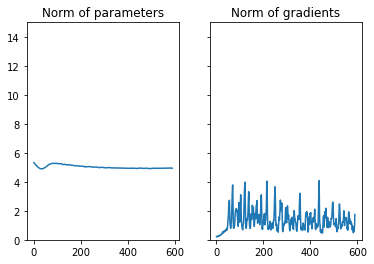

In [10]:
# effect of L2 regularisation
plot_trajectory(trajectory)

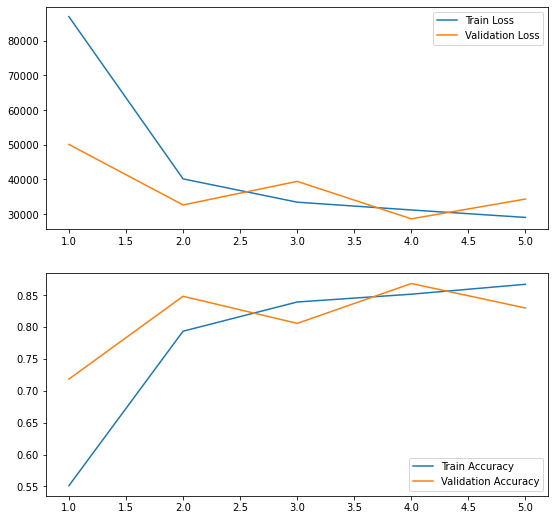

In [11]:
plot_loss_accuracy(train_loss_list,val_loss_list,train_acc_list,val_acc_list,num_epochs)

## L1 Implementation

$\mathcal{L}_0 (\hat{y}, y) + \lambda \cdot \vert\vert \Theta \vert\vert_1$

where $\vert\vert x \vert\vert_1 = \sum_{j=1}^d \vert x_j \vert$

In [12]:
def lossWithL1(y_hat,y):
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(y_hat,y)
    l1_lambda = 4e-2 # used same lambda as L2 norm to compare them
    l1_norm = sum(param.abs().sum() for name,param in model.named_parameters() if param.requires_grad if 'weight' in name)
    loss = loss + l1_lambda * l1_norm
    return loss

In [13]:
learn_rate = 0.1
num_epochs = 5

model_2 = MLP()
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=learn_rate)

trajectory_2 = {"parameters": [], "gradients": []}

train_loss_list_2, train_acc_list_2, val_loss_list_2, val_acc_list_2, trajectory_2 = train_model(model_2, trainloader, lossWithL1, optimizer_2, 
                                                                                                 num_epochs, validate_model = True, trajectory=trajectory_2, 
                                                                                                 device="cuda:0",early_stop=False)

Training on cuda:0
Epoch 1 completed. Loss - total: 796484.370880127 - average: 13.274739514668783; Performance: 0.5322833333333333
TESTING - loss 746374.3965148926 - performance 0.8348666666666666
Epoch 2 completed. Loss - total: 740258.1270751953 - average: 12.337635451253256; Performance: 0.8677333333333334
TESTING - loss 738091.1888122559 - performance 0.8776833333333334
Epoch 3 completed. Loss - total: 733552.8187561035 - average: 12.225880312601726; Performance: 0.90305
TESTING - loss 733813.1440734863 - performance 0.8980333333333334
Epoch 4 completed. Loss - total: 730628.8344421387 - average: 12.177147240702311; Performance: 0.91775
TESTING - loss 731331.3593444824 - performance 0.9161166666666667
Epoch 5 completed. Loss - total: 728656.2245483398 - average: 12.144270409138997; Performance: 0.9277166666666666
TESTING - loss 729020.8361816406 - performance 0.92465


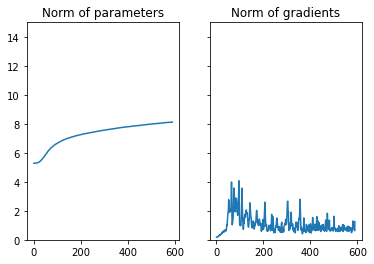

In [14]:
# effect of L1 regularisation
plot_trajectory(trajectory_2)

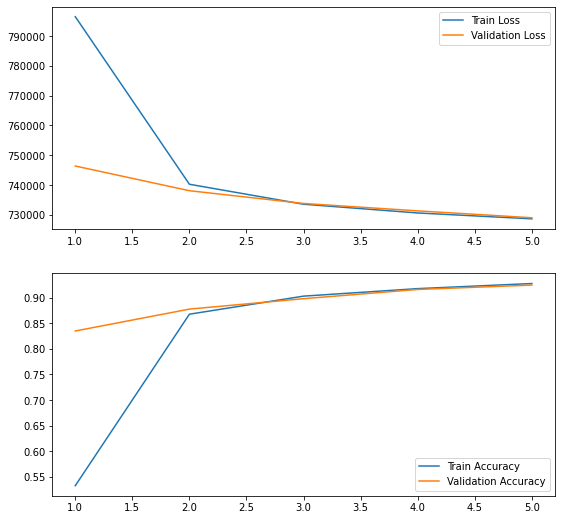

In [15]:
plot_loss_accuracy(train_loss_list_2,val_loss_list_2,train_acc_list_2,val_acc_list_2,num_epochs)

## $E_{opt}$

$E_{opt}(t) = min E_{va}(t') $

For this part, model training part is modified, loss and accuracy are stored in list to plot and observe the behaviour of the model

According to paper (tiny modification) this simple approach is implemented in tran_model function

1. Train only on the training set and evaluate the per-example error on the validation set once in a while, e.g. after every epoch.
2. Stop training as soon as the error on the validation set is higher than it was the last time it was checked.
4. Use the weights the network had in that previous step as the result of the training run.

In [16]:
learn_rate = 0.1
num_epochs = 25

model_3 = MLP()
loss_fn = nn.CrossEntropyLoss()
weight_decay = 1e-2
optimizer = torch.optim.SGD(model_3.parameters(), lr=learn_rate, weight_decay=weight_decay)

trajectory = {"parameters": [], "gradients": []}

train_loss_list, train_acc_list, val_loss_list, val_acc_list, trajectory = train_model(model_3, trainloader, loss_fn, optimizer, num_epochs, 
                                                                                       checkpoint_loc = "models",validate_model = True, trajectory=trajectory, 
                                                                                       device="cuda:0",early_stop=True)

Training on cuda:0
Epoch 1 completed. Loss - total: 72876.33986091614 - average: 1.2146056643486023; Performance: 0.5898
TESTING - loss 33794.560205459595 - performance 0.8264166666666667
Epoch 2 completed. Loss - total: 24765.334789276123 - average: 0.4127555798212687; Performance: 0.8764333333333333
TESTING - loss 24531.784903526306 - performance 0.87745
Epoch 3 completed. Loss - total: 20069.287410736084 - average: 0.3344881235122681; Performance: 0.9007166666666667
TESTING - loss 19682.70045375824 - performance 0.9014833333333333
Epoch 4 completed. Loss - total: 17164.93964099884 - average: 0.2860823273499807; Performance: 0.9165166666666666
TESTING - loss 20819.189003944397 - performance 0.8943833333333333


Here after the 4th epoch validation loss is increased. Therefore training is stopped. However better approach can be implemented by checking every 5th epoch as the paper stated.

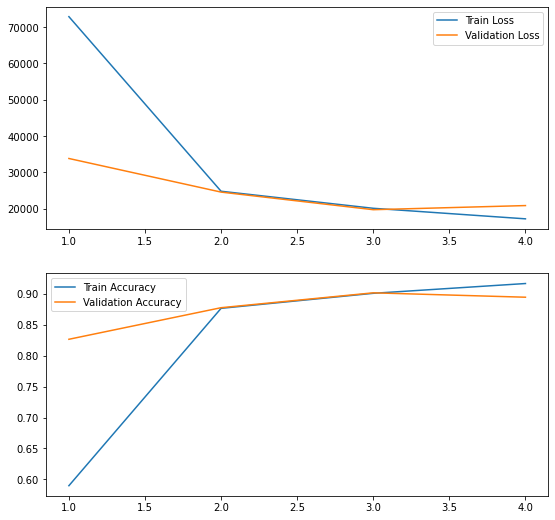

In [17]:
plot_loss_accuracy(train_loss_list,val_loss_list,train_acc_list,val_acc_list,len(val_acc_list))

## $E_{opt}$ with $GL(t)$

$GL(t) = 100. \big( \frac{E_{va}(t)}{E_{opt}(t)} \big)$

$GL_{\alpha}$ : stop after first epoch t with $GL(t) > \alpha$

In [18]:
def train_model(model, dataloader, loss_fn, optimizer, num_epochs, validate_model=False, checkpoint_loc=None, checkpoint_name="checkpoint.pt", performance=accuracy, trajectory=None, device=None, early_stop=False): # note: I've added a generic performance to replace accuracy and an object where to store the trajectory and the device on which to run our training

    # establish device
    if device is None:
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
    print(f"Training on {device}")

    # create the folder for the checkpoints (if it's not None)
    if checkpoint_loc is not None:
        os.makedirs(checkpoint_loc, exist_ok=True)
    
    model.to(device)
    model.train()

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    alpha = 40 # threshold for stopping criteria    
    E_opt = 9999999999 # set it to big value
    # epoch loop
    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        performance_meter = AverageMeter()

        train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance, trajectory, device)

        print(f"Epoch {epoch+1} completed. Loss - total: {loss_meter.sum} - average: {loss_meter.avg}; Performance: {performance_meter.avg}")
    
        train_loss_list.append(loss_meter.sum)
        train_acc_list.append(performance_meter.avg)
    # add also test_model step for each epoch to validate the model
        if validate_model == True:
            val_loss, val_perf = test_model(model, testloader, performance=accuracy, loss_fn = loss_fn, device = "cuda:0")
            val_loss_list.append(val_loss)
            val_acc_list.append(val_perf)
                       
        if early_stop == True:
            if val_loss < E_opt:
                E_opt = val_loss

            else:
                GL = ((val_loss / E_opt) -1) * 100
                print("GL is :",GL)
                if GL > alpha:
                    break
                    
                if checkpoint_name is not None and checkpoint_loc is not None:
                    # so we can have the latest model
                    checkpoint_dict = {
                        "parameters": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "epoch": epoch
                    }
                    torch.save(checkpoint_dict, os.path.join(checkpoint_loc, checkpoint_name))
                
        
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list, trajectory

In [21]:
learn_rate = 0.1
num_epochs = 25

model_4 = MLP()
loss_fn = nn.CrossEntropyLoss()
weight_decay = 1e-2
optimizer = torch.optim.SGD(model_4.parameters(), lr=learn_rate, weight_decay=weight_decay)

trajectory = {"parameters": [], "gradients": []}

train_loss_list, train_acc_list, val_loss_list, val_acc_list, trajectory = train_model(model_4, trainloader, loss_fn, optimizer, num_epochs, 
                                                                                       checkpoint_loc = "models",validate_model = True, trajectory=trajectory, 
                                                                                       device="cuda:0",early_stop=True)

Training on cuda:0
Epoch 1 completed. Loss - total: 96001.98383522034 - average: 1.6000330639203388; Performance: 0.44438333333333335
TESTING - loss 45394.68381309509 - performance 0.7448833333333333
Epoch 2 completed. Loss - total: 31947.433338165283 - average: 0.5324572223027547; Performance: 0.8356333333333333
TESTING - loss 35860.85273933411 - performance 0.7988666666666666
Epoch 3 completed. Loss - total: 22284.03979587555 - average: 0.3714006632645925; Performance: 0.8905333333333333
TESTING - loss 20202.431456565857 - performance 0.90205
Epoch 4 completed. Loss - total: 19119.35286092758 - average: 0.3186558810154597; Performance: 0.90725
TESTING - loss 17073.750727653503 - performance 0.9186666666666666
Epoch 5 completed. Loss - total: 16874.236063957214 - average: 0.28123726773262026; Performance: 0.91895
TESTING - loss 22345.03050994873 - performance 0.8841666666666667
GL is : 30.873589912248157
Epoch 6 completed. Loss - total: 15945.266417503357 - average: 0.2657544402917226

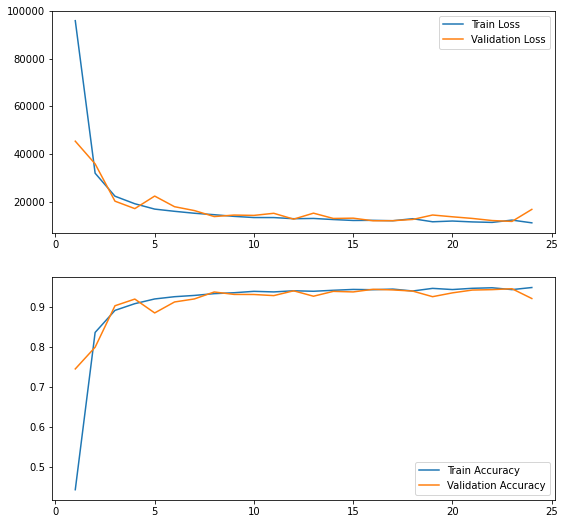

In [22]:
plot_loss_accuracy(train_loss_list,val_loss_list,train_acc_list,val_acc_list,len(val_acc_list))

In this implementation, when we have `GL > 40` which surpass the threshold so training is stopped.